# 進階房價預測

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score


train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

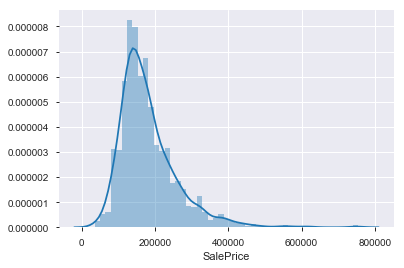

In [5]:
 # 原本的答案分佈
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.distplot(train['SalePrice'])

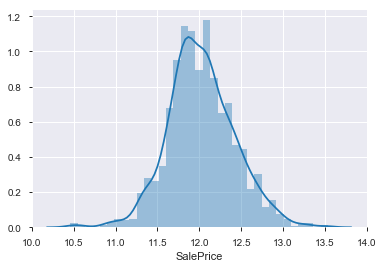

In [6]:
# 取log後的結果: 
sns.distplot(np.log1p(train["SalePrice"]))

In [9]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
train["SalePrice"] = np.log1p(train["SalePrice"])

In [11]:
# 得到所有數字形態的特徵
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].drop(["MSSubClass"]).index

In [16]:
# 觀察所有特徵左偏/右偏
pd.DataFrame(train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False))

,0
MiscVal,24.451640
PoolArea,14.813135
LotArea,12.195142
3SsnPorch,10.293752
LowQualFinSF,9.002080
KitchenAbvGr,4.483784
BsmtFinSF2,4.250888
ScreenPorch,4.117977
BsmtHalfBath,4.099186
EnclosedPorch,3.086696


In [17]:
# 利用boxcox1p拯救skewness
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.65]
skewed_feats = skewed_feats.index
all_data[skewed_feats] = boxcox1p(all_data[skewed_feats], 0.15)
pd.DataFrame(all_data[skewed_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False))

,0
PoolArea,15.119426
3SsnPorch,8.924822
LowQualFinSF,8.744143
MiscVal,5.597060
BsmtHalfBath,3.786685
KitchenAbvGr,3.698825
ScreenPorch,2.978396
BsmtFinSF2,2.563858
EnclosedPorch,2.025461
MasVnrArea,0.623664


In [18]:
# One-Hot Encoding
all_data = pd.get_dummies(all_data)
all_data = pd.get_dummies(all_data,  columns=["MSSubClass"])
all_data

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190
0,5.831328,19.212182,7,2.055642,2003,2003,8.059126,11.170327,0.000000,7.483296,...,0,0,0,0,0,0,0,0,0,0
1,6.221214,19.712205,6,2.602594,1976,1976,0.000000,12.062832,0.000000,8.897844,...,0,0,0,0,0,0,0,0,0,0
2,5.914940,20.347241,7,2.055642,2001,2002,7.646538,10.200343,0.000000,9.917060,...,0,0,0,0,0,0,0,0,0,0
3,5.684507,19.691553,7,2.055642,1915,1970,0.000000,8.274266,0.000000,10.468500,...,1,0,0,0,0,0,0,0,0,0
4,6.314735,21.325160,8,2.055642,2000,2000,9.391827,10.971129,0.000000,10.221051,...,0,0,0,0,0,0,0,0,0,0
5,6.337529,21.282283,5,2.055642,1993,1995,0.000000,11.267217,0.000000,5.802739,...,0,0,0,0,0,0,0,0,0,0
6,6.098626,19.907529,8,2.055642,2004,2005,7.944503,13.031093,0.000000,9.155750,...,0,0,0,0,0,0,0,0,0,0
7,NaN,20.023862,7,2.259674,1973,1973,8.511220,11.702249,4.597157,8.274266,...,0,0,0,0,0,0,0,0,0,0
8,5.392276,17.989871,7,2.055642,1931,1950,0.000000,0.000000,0.000000,11.987364,...,0,0,0,0,0,0,0,0,0,0
9,5.357203,18.712544,5,2.259674,1939,1950,0.000000,11.676516,0.000000,7.338607,...,0,0,0,0,0,0,0,0,0,1


In [19]:
# 針對所有缺失值填入
all_data = all_data.fillna(all_data.mean())
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
#imp = IterativeImputer()
#all_data = imp.fit_transform(all_data)  

In [20]:
# 拿回我們訓練/測試資料
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train["SalePrice"]

In [22]:
# 使用Lasso當作我們的模型選擇
model = Lasso(alpha=0.0004)
model.fit(X_train, y)

# 因為有對Sale Price做log1p, 所以要反向做expm1
preds = np.expm1(model.predict(X_test))
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})

solution.to_csv("lasso.csv", index = False)